# Análisis de Redes Sociales

Las redes sociales se han convertido en una plataforma para comunicarnos y en especial para expresar noticias, sentimientos y opiniones acerca de un tema en particular, de tal manera que analizar lo allí plasmado puede darnos una ventaja competitiva en el ámbito laboral y ademas un valor agregado en el conocimiento de las personas.


Para el presente trabajo vamos a usar un conjunto de datos de comentarios de las redes sociales de Facebook e Instagram, dicha base consta de comentarios que depositan los internáutas en las páginas asociadas a una inmobiliaria del pais, ademas, estuvo siendo recolectada y centralizada en un archivo compartido en Google Drive por una persona en particular. Contamos con las siguientes variables:

- Fuente
- Dia
- Mes
- Año
- Tipo
- Usuario
- Comentario
- label ($\textit{positivo}$, $\textit{negativo}$ o $\textit{neutro}$)
- Fecha


### Objetivo

#### General

- Conocer de que hablan las personas que interactuan en las redes sociales de la página en particular.

#### Específicos

- Implentar un modelo de clasificación con la finalidad de asignar el sentimiento a futuros comentarios.
- Analizar los temas o tópicos de los comentarios.
- Generar una visualización de los resultados.


### Autores

- Yuly Vanessa Chinchilla
- Diego Arturo Diaz

## Comencemos...

- librerias

In [174]:
import re
import numpy as np
import json
import pandas as pd

from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.linear_model import LogisticRegression

from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import silhouette_samples, silhouette_score

import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import plot_confusion_matrix

from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.io as pio
import plotly.express as px

In [170]:
import itertools
import os
import seaborn as sns

import sklearn.metrics as metrics
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split, LeaveOneOut, KFold, cross_val_score, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, roc_curve, auc, confusion_matrix, precision_score, recall_score, f1_score
plt.style.use('seaborn-white')

from tqdm.auto import tqdm
from tqdm.notebook import tqdm_notebook

import pyLDAvis.gensim
from gensim.models import LdaModel
from gensim.corpora import Dictionary
from pprint import pprint
from gensim.models.coherencemodel import CoherenceModel
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

import PIL.Image
from IPython.display import display
from wordcloud import WordCloud
from wordcloud import ImageColorGenerator

In [3]:
# Cargar datos

data = pd.read_excel('dfcomentarios.xlsx')
data.sample(5, random_state=20)

Fuente  Dia     Mes   Año               Tipo  \
1486   Facebook   27   Junio  2020            Lunaria   
2079  Instagram   25  Agosto  2020          Proyectos   
606    Facebook   10   Abril  2020            Payandé   
2058   Facebook   21  Agosto  2020  Hacienda San José   
1888  Instagram   31   Julio  2020             Asesor   

                               Usuario  \
1486          Gerardo Enriquez Sanchez   
2079               angieramirezcarreno   
606                Luz Marina Sanabria   
2058                     Marlon Forero   
1888  Reynel Francisco Cáceres Tabares   

                                             Comentario     label  Mes_id  \
1486  Estube allá y no me atendieron, aunque tenía c...  negativo       6   
2079  Llevo días esperando asesoría y no les importa...  negativo       8   
606                              Me interesa 3142637314  positivo       4   
2058   Buena tarde precios por favor\nForero9933@hot...  positivo       8   
1888  Me inscribí en la página, escribí mis datos po...  negativo       7   

          Fecha  
1486 2020-06-27  
2079 2020-08-25  
606  2020-04-10  
2058 2020-08-21  
1888 2020-07-31

In [4]:
# Dimensión

data.shape

(2351, 10)

In [336]:
df = pd.DataFrame(data.label.value_counts(normalize=False, ascending=False)).reset_index()
df.columns = ['sentimiento','cont']

trace = go.Bar(x=df['sentimiento'].values,
               y=df['cont'].values)

layout = go.Layout(title='Cantidad de sentimientos',width=600,height=450)

fig = go.Figure(data=[trace], layout=layout)
iplot(fig)

In [337]:
df1 = pd.DataFrame(data.label.value_counts(normalize=True, ascending=False)).reset_index()
df1.columns = ['sentimiento','cont']

trace = go.Bar(x=df1['sentimiento'].values,
               y=df1['cont'].values)

layout = go.Layout(title='Cantidad de sentimientos',width=600,height=450)

fig = go.Figure(data=[trace], layout=layout)
iplot(fig)

Apreciamos que la proporción entre las etiquetas no está balanceada, en especial para la categoria $\textit{neutro}$ ya que solo tenemos un $\approx 7.5\%$ de los registros, sin embargo esto es de esperarse ya que por lo general las personas pocas veces dejan un comentario neutro y por el contrario expresan su inconformidad o gratitud hacia alguien.

Por lo tanto, vamos a omitir la categoria $\textit{neutro}$ y solo nos vamos a enfocar en las dos restantes.

In [7]:
data2 = data[data['label']!='neutro']
data2.shape

(2174, 10)

# Modelo de Clasificación

### entrenamiento y prueba

Primero vamos a seleccionar los comentarios y la variable $\textit{label}$ con la siguiente especificación:

```python
positivo = 1
negativo = 0
```

In [21]:
# variable de comentarios
X = data2[['Comentario']]


# reemplazar la categoría
replace = {'positivo':1,
           'negativo':0
            }

data2.loc[:,'label_replace'] = data2.loc[:,'label'].apply(lambda nivel: replace[nivel])

# variable respuesta recategorizada
y = data2['label_replace'].values

In [11]:
# división del conjunto de datos en train y test con un 70% - 30% respectivamente

X_train, X_test, y_train, y_test = train_test_split(
    X, y, random_state=2611, test_size = 0.3, stratify=y)

In [12]:
#X['Comentario'].iloc[1810]

### Pre-procesamiento del texto

Más información de expresiones regulares [aquí](https://relopezbriega.github.io/blog/2015/07/19/expresiones-regulares-con-python/)

In [61]:
stopwords_sp = stopwords.words('spanish')
#stopwords_sp = stopwords_sp + ['viernes','dia','mañana','hoy']

def quitar_tildes(s):
    tildes = (
        ("á", "a"),
        ("é", "e"),
        ("í", "i"),
        ("ó", "o"),
        ("ú", "u"),
    )
    for origen, destino in tildes:
        s = s.replace(origen, destino)
    return s

def pre_procesado(texto):
    texto = texto.lower() # minúsculas
    texto = quitar_tildes(texto) # remove tildes
    texto = re.sub(r"([\w]+)@([\w]+)" + ".com", " ",texto) # remover correos
    texto = re.sub(r"https?://[^\s]+", " ", texto) # remover url
    texto = re.sub(r"@([\w]+)", " ", texto) # remover menciones
    texto = re.sub(r"[\W\d_]+", " ",texto) # remove caracteres especiales y números
    texto = texto.split() # tokenizar
    texto = [palabra for palabra in texto if palabra not in stopwords_sp] # stopwords
    texto = " ".join(texto)
    return texto

def pre_procesado_2(texto):
    texto = texto.lower() # minúsculas
    texto = quitar_tildes(texto) # remove tildes
    texto = re.sub(r"([\w]+)@([\w]+)" + ".com", " ",texto) # remover correos
    texto = re.sub(r"https?://[^\s]+", " ", texto) # remover url
    texto = re.sub(r"@([\w]+)", " ", texto) # remover menciones
    texto = re.sub(r"[\W\d_]+", " ",texto) # remove caracteres especiales y números
    texto = texto.split() # tokenizar
    texto = [palabra for palabra in texto if palabra not in stopwords_sp] # stopwords
    return texto

In [14]:
tfidf_vect = TfidfVectorizer(preprocessor=pre_procesado)

In [15]:
# calcula tfidf con las palabras de train
X_train_tf = tfidf_vect.fit_transform(X_train.Comentario.values)
y_train = y_train

# usando tfidf calculado en train, se transforma test
X_test_tf = tfidf_vect.transform(X_test.Comentario.values)
y_test = y_test

Vamos a incluir una columna con el comentario pre-procesado:

In [153]:
data2.loc[:,'Pre-Procesado'] = data2.loc[:,'Comentario'].apply(lambda texto: pre_procesado(texto))

In [155]:
data2.loc[:,'Pre-Procesado-2'] = data2.loc[:,'Comentario'].apply(lambda texto: pre_procesado_2(texto))

### entrenar modelo

Una vez calculada nuestra matriz tf-idf, vamos a hacer el modelamiento de clasificación, para ello vamos a usar la siguiente función que nos calculará las métricas de desempeño usando una busqueda exhaustiva de hiperparámetros.

In [24]:
scoring = ['roc_auc','accuracy','precision','recall','f1']

def BusquedaHiper(model,folds,score,param_grid):
    
    """
    Esta función nos permite visualizar los resultados del modelo por medio de una grilla.
    
    Parámetros:
    - model: Modelo de clasificación
    - fold: Número de pliegues en la validación cruzada
    - scoring: Score usado para evaluar la validación cruzada
    - param_grid: Grilla de hiperparámetros
    """

    kf = StratifiedKFold(n_splits=folds, random_state=None)

    GridS_model = GridSearchCV(model, param_grid=param_grid, verbose=0,
                        cv=kf, scoring=score, return_train_score=False, refit=False)

    GridS_model_fit = GridS_model.fit(X_train_tf, y_train)
    
    resultados = [GridS_model_fit.best_params_, GridS_model_fit.best_score_]

    return print(f"\nMejores hiperparámetros {score}: {resultados[0]}\n\nMétrica {score}: {resultados[1]}\n")

#### Regresión Logística

Es el modelo por excelencia para nuestra tarea de clasificación, primero, vamos a realizar una grilla de hiperparámetros.

In [17]:
LogisticRegresion = LogisticRegression()

param_grid_RL = {'solver': ['lbfgs','newton-cg','liblinear'],
                'class_weight': [None,'balanced'],
                'max_iter': [500],
                'random_state': [2611]}

Una vez personalizada la grilla, procedemos a realizar una búsqueda de los mejores valores asociados los hiperparámetros, para ello la validación cruzada es clave, ya que por cada valor que tomen los hiperparámetros se realizará un $\textit{Kfold=10}$.

In [25]:
print("\nRESULTADOS:\n")

for score in scoring:
    BusquedaHiper(LogisticRegresion,10,score,param_grid_RL)
    print("***************************")


RESULTADOS:


Mejores hiperparámetros roc_auc: {'class_weight': None, 'max_iter': 500, 'random_state': 2611, 'solver': 'liblinear'}

Métrica roc_auc: 0.9274744175047018

***************************

Mejores hiperparámetros accuracy: {'class_weight': 'balanced', 'max_iter': 500, 'random_state': 2611, 'solver': 'lbfgs'}

Métrica accuracy: 0.8711601307189543

***************************

Mejores hiperparámetros precision: {'class_weight': None, 'max_iter': 500, 'random_state': 2611, 'solver': 'liblinear'}

Métrica precision: 0.9292466353036355

***************************

Mejores hiperparámetros recall: {'class_weight': 'balanced', 'max_iter': 500, 'random_state': 2611, 'solver': 'lbfgs'}

Métrica recall: 0.7726438492063492

***************************

Mejores hiperparámetros f1: {'class_weight': 'balanced', 'max_iter': 500, 'random_state': 2611, 'solver': 'lbfgs'}

Métrica f1: 0.8334125105554719

***************************


#### matriz de Confusión Regresión Logística

seleccionando los hiperparámetros asociados a la métrica $auc$ tenemos:

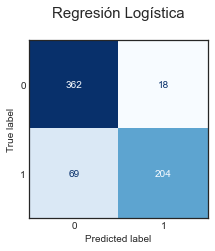

In [23]:
LogisticRegresion1 = LogisticRegression(class_weight=None, max_iter=500, 
                                        random_state=2611, solver='liblinear')

LogisticRegresion1.fit(X_train_tf, y_train)

fig, ax = plt.subplots(figsize = (4,4)) 
plot_confusion_matrix(LogisticRegresion1, X_test_tf, y_test, cmap = 'Blues', ax=ax).im_.colorbar.remove()
plt.title("Regresión Logística\n", fontsize = 15);

#y_pred_LR = LogisticRegresion1.predict(X_test_tf)
#print(confusion_matrix(y_test,y_pred_LR))

#### Random Forest

In [26]:
RandomForest = RandomForestClassifier()

param_grid_RF = {'n_estimators': [200,300,600],
                 'random_state': [2611],
                 'max_features': [None]}

In [27]:
print("\nRESULTADOS:\n")

for score in scoring:
    BusquedaHiper(RandomForest,10,score,param_grid_RF)
    print("***************************")


RESULTADOS:


Mejores hiperparámetros roc_auc: {'max_features': None, 'n_estimators': 600, 'random_state': 2611}

Métrica roc_auc: 0.8955049213037274

***************************

Mejores hiperparámetros accuracy: {'max_features': None, 'n_estimators': 200, 'random_state': 2611}

Métrica accuracy: 0.813953388372893

***************************

Mejores hiperparámetros precision: {'max_features': None, 'n_estimators': 200, 'random_state': 2611}

Métrica precision: 0.7585857276589056

***************************

Mejores hiperparámetros recall: {'max_features': None, 'n_estimators': 600, 'random_state': 2611}

Métrica recall: 0.824280753968254

***************************

Mejores hiperparámetros f1: {'max_features': None, 'n_estimators': 300, 'random_state': 2611}

Métrica f1: 0.7872011206967057

***************************


#### matriz de Confusión Random Forest

seleccionando los hiperparámetros asociados a la métrica $auc$ tenemos:

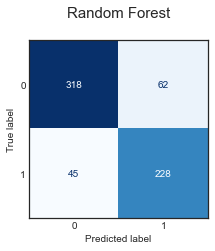

In [28]:
RandomForest1 = RandomForestClassifier(max_features = None, n_estimators= 600, random_state= 2611)

RandomForest1.fit(X_train_tf, y_train)

fig, ax = plt.subplots(figsize = (4,4)) 
plot_confusion_matrix(RandomForest1, X_test_tf, y_test, cmap = 'Blues', ax=ax).im_.colorbar.remove()
plt.title("Random Forest\n", fontsize = 15);

Observamos que las mejores métricas de desempeño la tiene el modelo de **Regresión Logistica**.

### palabras mas relevantes

In [67]:
# Vocabulario
vocab = {value:key for key, value in tfidf_vect.vocabulary_.items()}

# lista con la palabra y su peso relativo al modelo
palabra_peso = [(vocab[e[0]], round(e[1],2)) for e in zip(LogisticRegresion1.coef_[0].argsort(),
                                                          sorted(LogisticRegresion1.coef_[0]))]

# función con 'n' palabras mas/menos releventes del modelo (variable respuesta: positivo)
def palabras_relevantes(n):
    print(f"\nLas {n} palabras menos relevantes:\n")
    for i in range(0,n):
        print(palabra_peso[i])
    print("*************")
    
    print(f"\nLas {n} palabras mas relevantes:\n")
    for i in range(0,n):
        print(palabra_peso[-(i+1)])
    print("*************")

In [68]:
palabras_relevantes(10)


Las 10 palabras menos relevantes:

('nunca', -2.15)
('cita', -1.76)
('aun', -1.52)
('esperando', -1.44)
('llamaron', -1.41)
('quedaron', -1.21)
('llamado', -1.17)
('dijeron', -1.16)
('solo', -1.16)
('contestan', -1.11)
*************

Las 10 palabras mas relevantes:

('informacion', 3.99)
('interesa', 3.66)
('numero', 3.54)
('favor', 3.25)
('correo', 2.5)
('interesado', 2.12)
('gracias', 2.0)
('interesada', 1.88)
('info', 1.88)
('inf', 1.69)
*************


#### ejemplo predicción

In [59]:
def prediccion(texto):
    
    frases_tf = tfidf_vect.transform([texto])
    pred_logreg = LogisticRegresion1.predict(frases_tf)
    print(f"El comentario: {texto}\n")
        
    if pred_logreg[0] == 1:
        return print("se clasifica en: positivo\n*****************\n")
    else:
        return print("se clasifica en: negativo\n*****************\n")

In [37]:
prueba = ['estoy muy interesado en recibir informacion por favor llamenme 316984789','Es mala constrcutora no le paren bolas']

In [60]:
for text in prueba:
    prediccion(text)

El comentario: estoy muy interesado en recibir informacion por favor llamenme 316984789

se clasifica en: positivo
*****************

El comentario: Es mala constrcutora no le paren bolas

se clasifica en: negativo
*****************



**Finalmente observamos que el modelo predice correctamente.**

# Análisis de Tópicos

Hasta el momento tenemos un clasificador eficiente de comentarios, sin embargo si quisieramos conocer los temas mas relevantes a los que se refieren nuestros internautas necesitariamos otro tipo de análisis; para resolver este tipo de preguntas, uno de los modelos mas usados es el $\textit{Latent Dirichlet Allocation (LDA)}$ el cual permite, principalmente, que conjuntos de observaciones puedan ser explicados por grupos no observados que explican porqué algunas partes de los datos son similares.

Uno de los hiperparámetros mas importantes del modelo LDA son el $\textit{número de tópicos}$, para hallar el más óptimo, necesitamos, en primera medida, conocer las métricas de desempeño mas importantes:

- **Perplejidad**: Es una medida de que tan "seguro" está el modelo de que la predicción que hará sobre un espacio muestral (vocabulario) es correcta, o bien, que tan perplejo está, de tal manera queremos tener un modelo que prediga lo mejor posible secuencias de texto; es decir, basados en las palabras anteriores observadas, predecir la de mayor probabilidad de ocurrencia en una próxima iteración y por tanto el objetivo será minimizarlo.(*)


- **Coherencia**: Esta medida puntúa un solo tema midiendo el grado de similitud semántica entre las palabras de puntuación alta en el tema, en otras palabras, se dice que un conjunto de afirmaciones o hechos es coherente, si se apoyan entre sí. Por tanto, un conjunto de hechos coherente se puede interpretar en un contexto que cubra todos o la mayoría de los hechos. El objetivo será maximizarlo.(**)

(*) tomado de [aquí](https://es.quora.com/C%C3%B3mo-puedo-comparar-dos-implementaciones-diferentes-de-LDA-Latent-Dirichlet-Allocation)

(**) tomado de [aquí](https://towardsdatascience.com/evaluate-topic-model-in-python-latent-dirichlet-allocation-lda-7d57484bb5d0)

### número óptimo de tópicos

In [81]:
# Crear una representación de los documentos en forma de diccionario
dictionary = Dictionary(data2['Pre-Procesado-2'].values)

# Filtrar palabras muy frecuentes o infrecuentes
dictionary.filter_extremes(no_below=5, no_above=0.5)

corpus = [dictionary.doc2bow(text) for text in data2['Pre-Procesado-2'].values]

In [133]:
coherence_cv = []
perplej = []

topics = np.arange(2,11)

for t in tqdm_notebook(topics):
    
    #Train the topic model
    model_LDA = LdaModel(corpus=corpus, random_state=2611, id2word=dictionary, num_topics=t, passes=60)
    
    coherence_model_lda = CoherenceModel(model=model_LDA, 
                                     corpus=corpus, 
                                     texts=data2['Pre-Procesado-2'].values, 
                                     dictionary=dictionary, 
                                     coherence='c_v')
    
    coherence_lda = coherence_model_lda.get_coherence()  
    perplejidad = model_LDA.log_perplexity(corpus)
    
    perplej.append(perplejidad) 
    coherence_cv.append(coherence_lda)

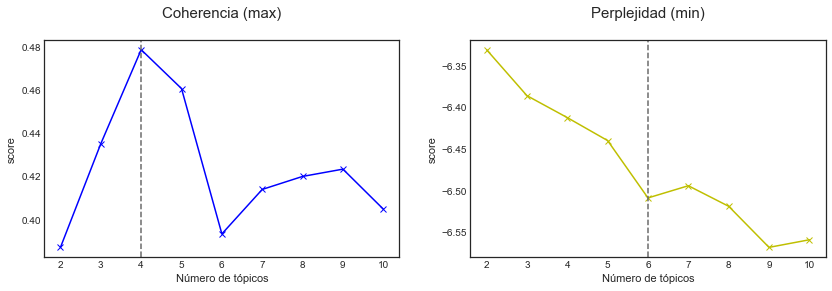

In [134]:
plt.figure(figsize=(14, 4))

plt.subplot(1, 2, 1)
plt.plot(topics, coherence_cv, 'bx-', label='coh')
plt.axvline(x=4,color='dimgray',linestyle='--')
plt.xticks(topics)
plt.ylabel('score', size=11)
plt.xlabel('Número de tópicos', size=11)
plt.title('Coherencia (max)\n', size=15)

plt.subplot(1, 2, 2)
plt.plot(topics, perplej, 'yx-', label='ppj')
plt.axvline(x=6,color='dimgray',linestyle='--')
plt.xticks(topics)
plt.ylabel('score', size=11)
plt.xlabel('Número de tópicos', size=11)
plt.title('Perplejidad (min)\n', size=15)

plt.show()

observando la gráfica se puede evidenciar que el número óptimo de tópicos está entre $t=4$ y $t=6$. Tomemos el valor mínimo $t=4$.

Ahora si, una vez hallado el $t$ óptimo, vamos a entrenar el modelo LDA:

In [136]:
#Train the topic model
model_LDA_f = LdaModel(corpus=corpus, random_state=2611, id2word=dictionary, num_topics=4, passes=60)

## visualizando

In [137]:
pprint(model_LDA_f.print_topics(num_words=7))

[(0,
  '0.026*"constructora" + 0.021*"si" + 0.018*"tiempo" + 0.014*"bolivar" + '
  '0.013*"atencion" + 0.013*"asesores" + 0.013*"cliente"'),
 (1,
  '0.020*"respuesta" + 0.019*"dinero" + 0.018*"si" + 0.016*"mas" + '
  '0.016*"dias" + 0.016*"esperando" + 0.016*"nadie"'),
 (2,
  '0.076*"informacion" + 0.038*"proyecto" + 0.035*"favor" + 0.031*"gracias" + '
  '0.028*"buenas" + 0.027*"cita" + 0.026*"correo"'),
 (3,
  '0.049*"constructora" + 0.038*"bolivar" + 0.019*"conjunto" + 0.018*"q" + '
  '0.012*"mas" + 0.011*"mala" + 0.011*"daños"')]


Intrepretación:

- $\textit{tópico 0}$ está enfocado en la atención que la compañia dá hacia sus clientes y/o personas interesadas, ya sea a traves de sus asesores o por otro medio de comunicación.

- $\textit{tópico 1}$ hace referencia a las quejas y solicitudes de respuesta que pueden involucrar dinero.

- $\textit{tópico 2}$ habla acerca de la información que los internáutas solicitan. 

- $\textit{tópico 3}$ son comentarios de desprestigio y de reclamos hacia la compañia.

In [138]:
coherence_model_lda_f = CoherenceModel(model=model_LDA_f, 
                                     corpus=corpus, 
                                     texts=data2['Pre-Procesado-2'].values, 
                                     dictionary=dictionary, 
                                     coherence='c_v')
    
print(f"\nLa coherencia del modelo es: {coherence_model_lda_f.get_coherence()}\n")
print(f"La perplejidad del modelo es: {model_LDA_f.log_perplexity(corpus)}")


La coherencia del modelo es: 0.47880087664390963

La perplejidad del modelo es: -6.412399907863572


In [139]:
lda_display = pyLDAvis.gensim.prepare(model_LDA_f, corpus, dictionary, sort_topics=True)
pyLDAvis.display(lda_display)

Del gráfico anterior, las burbujas en el lado izquierdo representan un tema y cuanto más grande es la burbuja, más frecuente es ese tema. El modelo será bueno si tiene burbujas grandes que no se superponen repartidas por todo el gráfico.

#### ejemplo LDA

In [144]:
frase = 'necesito que me respondan porque tengo un daño en mi apto'
pre_frase = pre_procesado_2(frase)

d = dictionary.doc2bow(pre_frase)
topics = model_LDA_f.get_document_topics(d)
topics

[(0, 0.0527152), (1, 0.58848274), (2, 0.052264374), (3, 0.3065377)]

Se observa que el modelo lo asigna en $\approx 59\%$ al $\textit{tópico 1}$ lo cual **coincide con nuestra interpretación**.

### Nube de palabras

In [163]:
pos = PIL.Image.open("positivo.jpg")
neg = PIL.Image.open("negativo.jpg")

mask_pos = np.array(pos)
mask_neg = np.array(neg)

palabras_pos = data2[data2['label']=='positivo']['Pre-Procesado'].str.cat(sep=' ')
palabras_neg = data2[data2['label']=='negativo']['Pre-Procesado'].str.cat(sep=' ')

In [357]:
def nube(mask, palabras):
    wordcloud = WordCloud(width=600, height=400,
                      max_font_size=150, max_words=250,
                      background_color='black', colormap='Blues',
                      stopwords=None, random_state=None,
                      mask=mask, contour_width=0.2, contour_color='white').generate(palabras)

    #wordcloud.to_file("calabaza.png")

    plt.figure(figsize=(10,8))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.tight_layout(pad=0)
    plt.show()

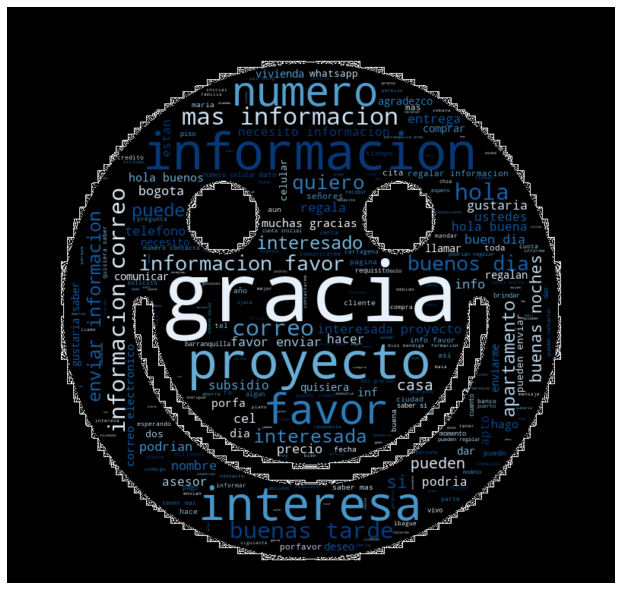

In [363]:
nube(mask_pos, palabras_pos)

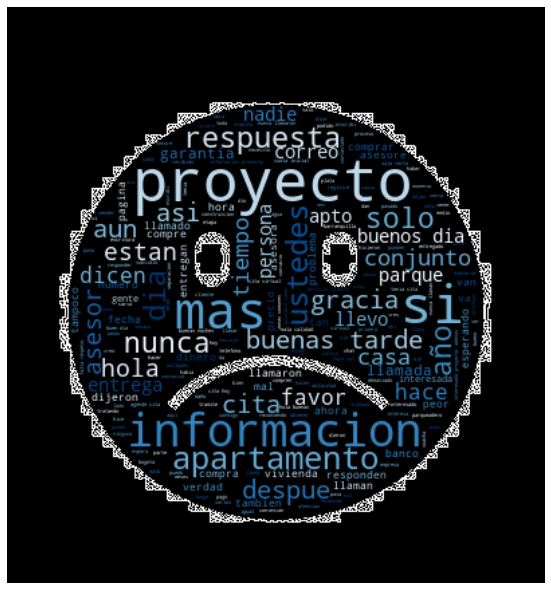

In [362]:
nube(mask_neg, palabras_neg)

### Número de comentarios por dia

In [227]:
tsp = pd.DataFrame(data2['Fecha'][data2['label']=='positivo'].value_counts(normalize=False, ascending=False)).reset_index()
tsp.columns = ['Fecha','Cont']
tsp = tsp.sort_values('Fecha')

tsn = pd.DataFrame(data2['Fecha'][data2['label']=='negativo'].value_counts(normalize=False, ascending=False)).reset_index()
tsn.columns = ['Fecha','Cont']
tsn = tsn.sort_values('Fecha')

In [245]:
trace1 = go.Scatter(x=tsp.Fecha.values,
                    y=tsp.Cont.values,
                    text=[f"Fecha: {f}<br>Comentarios: {c}" for f,c in zip(tsp.Fecha.values,tsp.Cont.values)],
                    hoverinfo='text',
                    mode='lines',
                    name='positivo')

trace2 = go.Scatter(x=tsn.Fecha.values,
                    y=tsn.Cont.values,
                    text=[f"Fecha: {f}<br>Comentarios: {c}" for f,c in zip(tsn.Fecha.values,tsn.Cont.values)],
                    hoverinfo='text',
                    mode='lines',
                    name='negativo',
                    line={'color':'orange'})


frames = [dict(data= [dict(type='scatter',
                           x=tsp['Fecha'][:k+1],
                           y=tsp['Cont'][:k+1]),
                      dict(type='scatter',
                           x=tsn['Fecha'][:k+1],
                           y=tsn['Cont'][:k+1]),
                     ],
               traces= [0, 1],  
              )for k  in  range(1, len(tsp)-1)]

layout = go.Layout(width=1100,
                   height=550,
                   showlegend=True,
                   legend=dict(x=1,y=0.9), 
                   #hovermode='x unified',
                   title='Número de comentarios por tipo de sentimiento',
                   updatemenus=[
                        dict(
                            type='buttons', 
                            showactive=False,
                            y=1.05,
                            x=1.07,
                            xanchor='right',
                            yanchor='top',
                            pad=dict(t=0, r=10),
                            buttons=[dict(label='Play',
                                          method='animate',
                                          args=[None,
                                                dict(frame=dict(duration=3,
                                                                redraw=False),
                                                     transition=dict(duration=0),
                                                     fromcurrent=True,
                                                     mode='immediate'
                                                    )
                                               ]
                                          )
                                    ]
                            )
                       ]              
                  )

fig = go.Figure(data=[trace1,trace2], frames=frames, layout=layout)
fig.show()

In [296]:
bar = pd.DataFrame(data2.groupby(['Fecha','label']).size()).reset_index()
bar.columns = ['Fecha','label','Cont']
bar = bar.sort_values('Fecha')
bar
bar.to_csv('bar.csv', index_label=False)

In [315]:
df = pd.read_csv('bar.csv')

In [313]:
px.scatter(df, x="Fecha", y="Cont",
            color="label", animation_frame="Fecha", animation_group="label", size="Cont",
           range_y=[0,22],
           range_x=['2019-07-20','2020-11-30'],
           width=1100,height=550
          )

**Observaciones finales:**

- Mientras intentábamos correr tf-idf con regex de correos y urls se estaba demorando demasiado, nos tocó editar el regex y que fuera menos complejo.
- Realizar un análisis de sentimiento usando la libreria $Vader$ y de esas manera comparar la etiqueta original con la etiqueta que nos arroja el modelo.
- En el análisis de tópicos seria interesante hallar los temas mas importantes por cada sentimiento.
- Al hallar la matriz $tf-idf$ puede ser de gran utilidad usar bigramas para el análisis posterior.